In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

In [2]:
path = "1.png"

In [3]:
def show_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_grayscale_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

def convolution(img, kernel):
    grayscale = False
    if img.ndim == 2:
        grayscale = True
        img = img.reshape((img.shape[0], img.shape[1], 1))
    height, width, channels = img.shape
    kernel_h, kernel_w = kernel.shape
    output_w = width - kernel_w + 1
    output_h = height - kernel_h + 1
    result = np.zeros(img.shape)
    
    left_padding_size = (width - output_w) // 2
    top_padding_size = (height - output_h) // 2
    
    new_img = np.zeros((height + top_padding_size * 2, width + left_padding_size * 2, channels))
    for channel in range(channels):
        for i in range(height):
            for j in range(width):
                new_img[i + top_padding_size, j + left_padding_size, channel] = img[i,j,channel]
    
    for channel in range(channels):
        for i in range(height):
            for j in range(width):
                element = np.sum(np.multiply(kernel, new_img[i:i+kernel_h, j:j+kernel_w, channel]))
                result[i,j,channel] = element
    
    if grayscale:
        result = result.reshape((result.shape[0], result.shape[1]))
    return result

In [4]:
img = cv2.imread(path)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

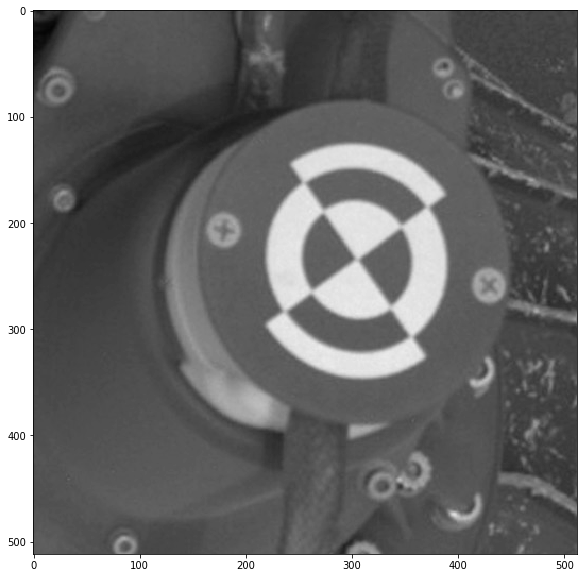

In [5]:
show_grayscale_image(gray_img)

In [6]:
def gauss_pdf(sigma, x, y):
    return np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

def gauss_kernel(sigma=1, size=5):
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            kernel[i, j] = gauss_pdf(sigma, i - size // 2, j - size // 2)

    return kernel

filtered_img = convolution(gray_img, gauss_kernel(1.5))

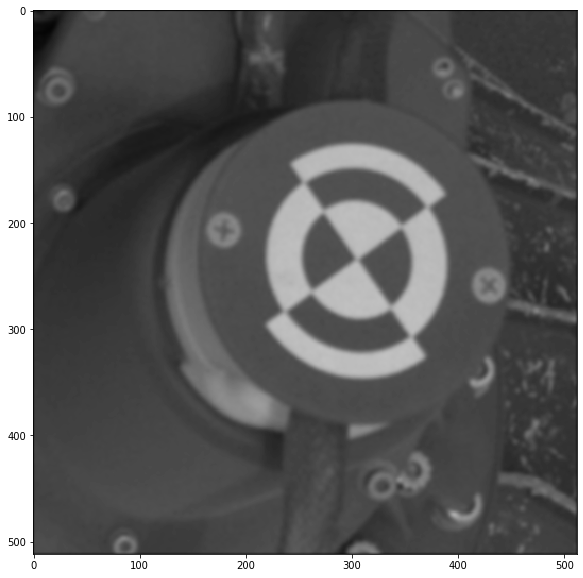

In [7]:
show_grayscale_image(filtered_img)

In [8]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolution(img, Kx)
    Iy = convolution(img, Ky)
    
    G = np.hypot(Ix, Iy)
    magnitude = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (magnitude, theta)

magnitude, theta = sobel_filters(filtered_img)

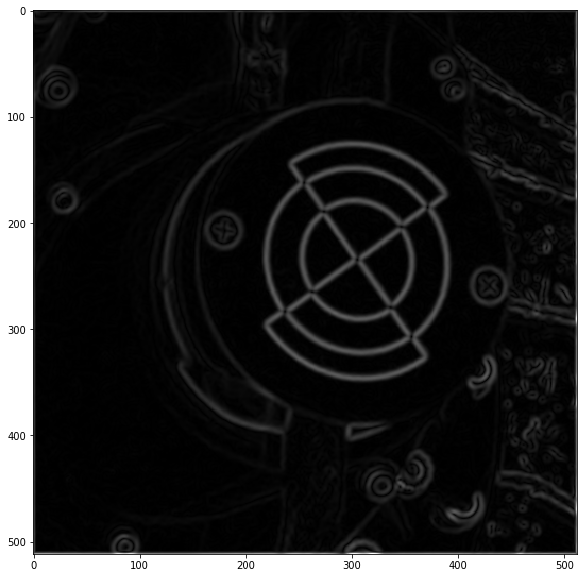

In [9]:
show_grayscale_image(magnitude)

In [10]:
def non_max_suppression(magnitude, theta):
    M, N = magnitude.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    Z[i,j] = magnitude[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

suppress_magnitude = non_max_suppression(magnitude, theta)

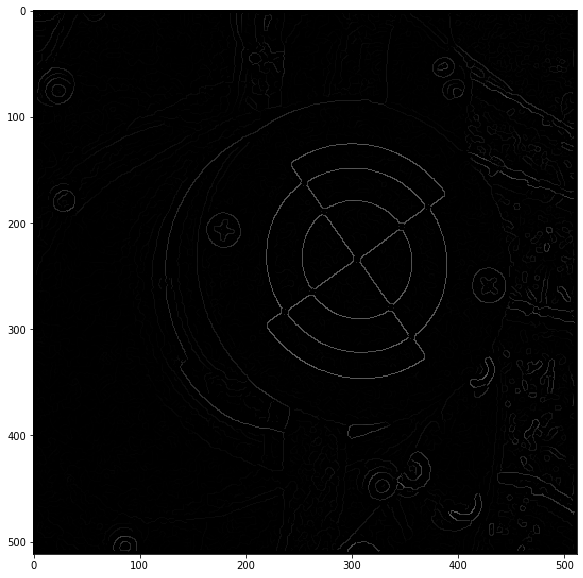

In [11]:
show_grayscale_image(suppress_magnitude)

In [12]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

suppress_magnitude_threshold, weak, strong = threshold(suppress_magnitude, 0.1, 0.8)

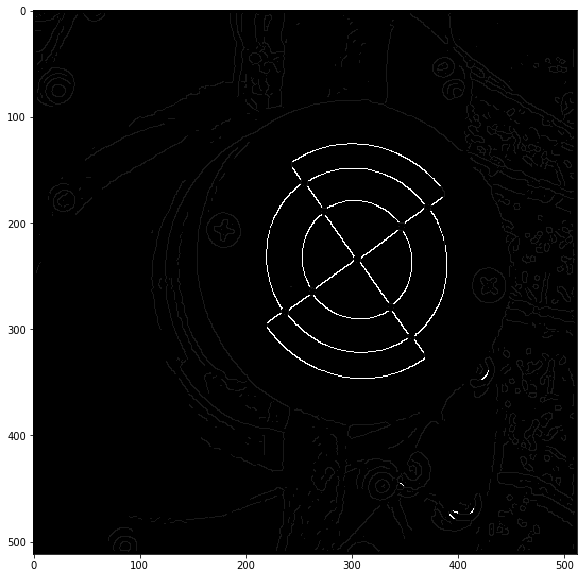

In [13]:
show_grayscale_image(suppress_magnitude_threshold)

In [14]:
def hysteresis(img, weak, strong=255):

    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                     , dtype=np.uint8   img[i, j] = 0
                except IndexError as e:
                    pass

    return img

result = hysteresis(suppress_magnitude_threshold, weak, strong)

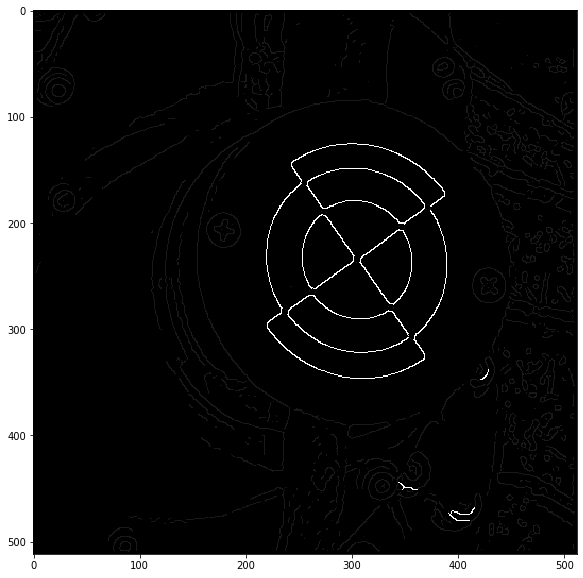

In [15]:
show_grayscale_image(result)

In [16]:
def hough_lines(img):
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    height, width = img.shape
    rho_max = int(np.hypot(img.shape[0], img.shape[1]))
    rhos = np.linspace(-rho_max, rho_max, rho_max * 2.0)
    
    accumulator = np.zeros((len(rhos), len(thetas)))
    for i in tqdm_notebook(range(height)):
        for j in range(width):
            if img[i, j]:
                for theta_index, theta in enumerate(thetas):
                    rho = i * np.cos(theta) + j * np.sin(theta)
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx, theta_index] += 1
    return accumulator, rhos, thetas

acc, rhos, thetas = hough_lines(result)

/home/dima/UCU/ComputerVision/Repos/ComputerVision/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [17]:
def get_k_and_b(acc, rhos, thetas, limit=10):
    result = []
    i_s, j_s = np.unravel_index(np.argsort(-acc.flatten())[:limit], acc.shape)

    for i, j in zip(i_s, j_s):
        rho = rhos[i]
        theta = thetas[j]
        k = -1 / np.tan(theta)
        b = rho / np.sin(theta)
        result.append((k,b))
    return result

k_and_b = get_k_and_b(acc, rhos, thetas)

In [18]:
k_and_b

[(-1.4281480067421146, 639.4148354262277),
 (0.7002075382097098, 139.8752893699339),
 (-1.3763819204711736, 625.660430071119),
 (0.24932800284318063, 391.3881680344427),
 (0.2679491924311227, 387.97887077267325),
 (-1.32704482162041, 614.4003417730537),
 (0.726542528005361, 134.20605930133857),
 (-1.32704482162041, 617.7259187244641),
 (-1.3763819204711736, 627.3629074318566),
 (6.123233995736766e-17, 507.8507256392536)]

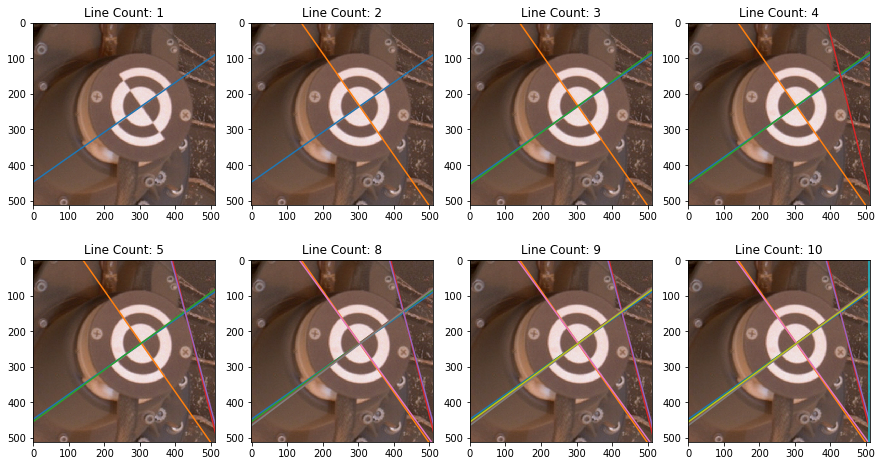

In [19]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(15, 8)

line_counts = [1, 2, 3, 4, 5, 8, 9, 10]
xs = np.arange(img.shape[0])

for i, line_count in enumerate(line_counts):
    row = i // 4
    col = i % 4
    axis = axes[row, col]
    current_k_and_b = k_and_b[0:line_count]
    for k, b in current_k_and_b:
        ys = k * xs + b
        axis.plot(ys, xs)
    axis.set_title(f"Line Count: {line_count}")
    axis.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))